##Description <br>
This is an example of few-shot classification on hyperspectral images. Based on https://github.com/sicara/easy-few-shot-learning/blob/master/notebooks/my_first_few_shot_classifier.ipynb


##Setup

In [ ]:
!gdown http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
!gdown http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

Downloading...
From: http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
To: /content/Indian_pines_corrected.mat
100% 5.95M/5.95M [00:11<00:00, 523kB/s]
Downloading...
From: http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
To: /content/Indian_pines_gt.mat
100% 1.12k/1.12k [00:00<00:00, 855kB/s]


In [ ]:
!pip install easyfsl

     |████████████████████████████████| 49 kB 3.9 MB/s 


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
 
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from operator import truediv
 
from plotly.offline import init_notebook_mode
 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os

In [ ]:
def applyFA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    fa = FactorAnalysis(n_components=numComponents, random_state=0)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, fa
    

In [ ]:
def loadData(name):
    data_path = os.getcwd()
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=8, removeZeroLabels = True):
    margin = int((windowSize) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin , c - margin:c + margin ]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
test_ratio = 0.3
windowSize = 6

## Download and process daatset

In [ ]:
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

X,fa = applyFA(X,numComponents=3)

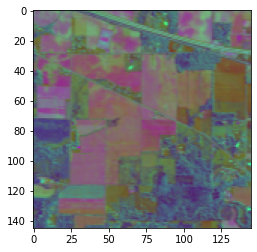

In [ ]:
import matplotlib.pyplot as plt
plt.imshow((X - np.min(X))*(255/np.max(X - np.min(X)))/255)

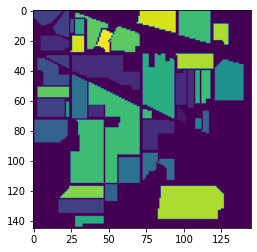

In [ ]:
plt.imshow(y)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize, removeZeroLabels=False)

X.shape, y.shape

((21025, 6, 6, 3), (21025,))

In [ ]:
np.unique(y)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])

In [ ]:
X, y = torch.from_numpy(X), torch.from_numpy(y)
X = X.permute(0, 3, 1, 2)

In [ ]:
X = torch.cat((X, transforms.RandomHorizontalFlip(p=1)(X)))
y = torch.cat((y, y))
X = torch.cat((X, transforms.RandomVerticalFlip(p=1)(X)))
y = torch.cat((y, y))
X = torch.cat((X, transforms.GaussianBlur(3)(X)))
y = torch.cat((y, y))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

(torch.Size([117740, 3, 6, 6]),
 torch.Size([50460, 3, 6, 6]),
 torch.Size([117740]),
 torch.Size([50460]))

In [ ]:
class HyperspectralDataset(torch.utils.data.Dataset):
    def __init__(self, data, label, train=True, transform=None):
        self.data = data.float()
        self.label = label.tolist()
        self.transform = transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        x = self.data[idx]

        if self.transform:
          x = self.transform(x)

        return x, self.label[idx]

    def get_labels(self):
        return self.label

In [ ]:
train_set = HyperspectralDataset(Xtrain, ytrain)
test_set = HyperspectralDataset(Xtest, ytest, train = False)

In [ ]:
N_WAY = len(y.unique())  # Number of classes in a task
N_SHOT = 10  # Number of images per class in the support set
N_QUERY = 20  # Number of images per class in the query set
N_EVALUATION_TASKS = 100
N_VALIDATION_TASKS = 100
N_TRAINING_EPISODES = 500

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

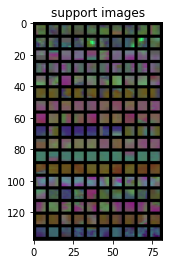

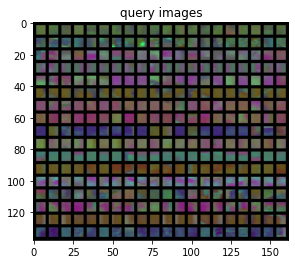

In [ ]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images((example_support_images - torch.min(example_support_images))*(255/torch.max(example_support_images - torch.min(example_support_images)))/255, "support images", images_per_row=N_SHOT)
plot_images((example_query_images - torch.min(example_query_images))*(255/torch.max(example_query_images - torch.min(example_query_images)))/255, "query images", images_per_row=N_QUERY)




## Train

In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
if torch.cuda.is_available():
  model.cuda()

False

In [ ]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images, support_labels, query_images)
            .detach()
            .data,
            1,
        )[1]
        == query_labels
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            if torch.cuda.is_available():
              correct, total = evaluate_on_one_task(support_images.cuda(), support_labels.cuda(), query_images.cuda(), query_labels.cuda())
            else:
              correct, total = evaluate_on_one_task(
                  support_images, support_labels, query_images, query_labels
              )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )




In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images, support_labels, query_images
    )

    loss = criterion(classification_scores, query_labels)
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
log_update_frequency = 10

all_loss = []
all_acc = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        if torch.cuda.is_available():
          loss_value = fit(support_images.cuda(), support_labels.cuda(), query_images.cuda(), query_labels.cuda())
          correct, total = evaluate_on_one_task(support_images.cuda(), support_labels.cuda(), query_images.cuda(), query_labels.cuda())
        else:
          loss_value = fit(support_images, support_labels, query_images, query_labels)
          correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)
        all_acc.append(correct/total)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix({'loss': sliding_average(all_loss, log_update_frequency),
                                    'acc': sliding_average(all_acc, log_update_frequency)})

100%|██████████| 500/500 [30:07<00:00,  3.62s/it, loss=0.225, acc=0.944]


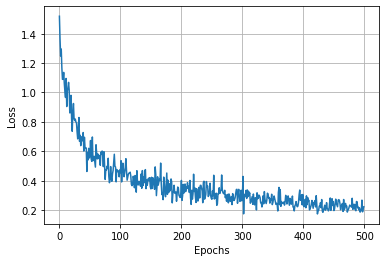

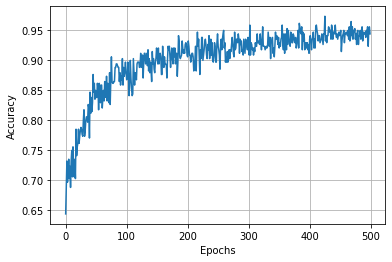

In [ ]:
plt.grid() 
plt.plot(all_loss)
plt.ylabel('Loss') 
plt.xlabel('Epochs')  
plt.show()
plt.grid() 
plt.plot(all_acc)
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.show()

In [ ]:

evaluate(test_loader)

100%|██████████| 100/100 [00:44<00:00,  2.26it/s]

Model tested on 100 tasks. Accuracy: 91.68%


In [ ]:
torch.save(model, 'PrototypicalNetworks.pt')